In [ ]:
#!pip install -U tensorflow==2.15.1

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras


2024-11-11 07:51:13.989128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.version.VERSION)

2.15.0


In [3]:
colnames=['country', 'description', 'points', 'price', 'variety', 'winery']
df = pd.read_csv("../datasets/wine-reviews.csv", usecols=colnames)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   description  129971 non-null  object 
 2   points       129971 non-null  int64  
 3   price        120975 non-null  float64
 4   variety      129970 non-null  object 
 5   winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.9+ MB


,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df = df.dropna(subset=["description", "points"])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


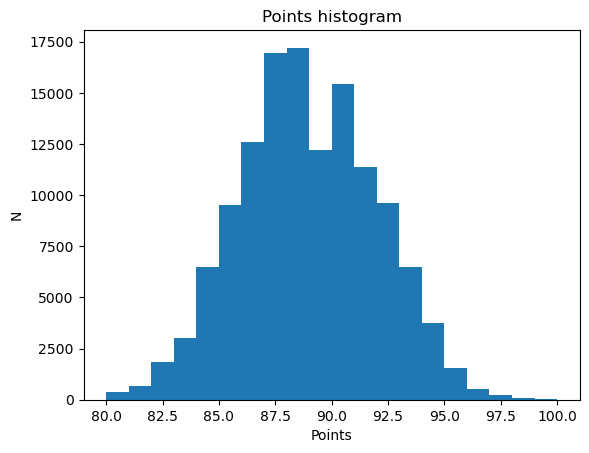

In [6]:
plt.hist(df.points, bins=20)
plt.title('Points histogram')
plt.ylabel ('N')
plt.xlabel('Points')
plt.show()

# define quality label for wine

In [7]:
df['label'] = (df.points > 90).astype(int)
df = df[['description', 'label']]

In [8]:
len(df[df["label"] == 1]), len(df[df["label"] == 0]),

(33635, 96336)

In [9]:
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [10]:
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,0
129967,Citation is given as much as a decade of bottl...,0
129968,Well-drained gravel soil gives this wine its c...,0
129969,"A dry style of Pinot Gris, this is crisp with ...",0
129970,"Big, rich and off-dry, this is powered by inte...",0


# split into datasets

In [11]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/home/heidless/miniconda3/envs/ml_db/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
len(train), len(val), len(test),

(103976, 12997, 12998)

In [13]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [14]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# embedding + model

In [15]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [16]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.26511788, -0.15988895,  0.06163435, ..., -0.15192316,
        -0.2868969 , -0.00665556],
       [ 0.2691426 , -0.39794314,  0.18778875, ...,  0.08330052,
        -0.15718412, -0.07425858],
       [ 0.32076272, -0.27701393,  0.0608661 , ..., -0.13132866,
        -0.3782253 ,  0.1171029 ],
       ...,
       [ 0.5426136 , -0.29652554, -0.07007001, ...,  0.15911573,
        -0.09481753, -0.17346977],
       [ 0.30325207, -0.36143687,  0.03716294, ..., -0.04390262,
         0.07354113,  0.01301692],
       [ 0.29183728,  0.12087911, -0.17514381, ..., -0.11805996,
        -0.01504651,  0.07094739]], dtype=float32)>

## create model

In [43]:
def create_model():
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

    return model
    
# Display the model's architecture
# model.summary()

# instantiate MODEL

In [44]:
# Create a basic model instance
model_FF = create_model()

In [45]:
model_FF.evaluate(train_data)

102/102 [==============================] - 5s 46ms/step - loss: 0.6956 - accuracy: 0.4788


[0.6956065893173218, 0.47880280017852783]

In [46]:
model.evaluate(valid_data)

13/13 [==============================] - 1s 50ms/step - loss: 0.7583 - accuracy: 0.2615


[0.7583044171333313, 0.2615218758583069]

In [47]:
# # checkpoint_path = "wine_0/cp.weights.h5" # If you're saving the whole model, you would use the .keras extension instead
# checkpoint_path = "wine_0/cp.keras"
# # checkpoint_path = "wine_0/cp-{epoch:04d}.keras"

# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

In [48]:
# # checkpoint_path = "wine_0/cp.weights.h5" # If you're saving the whole model, you would use the .keras extension instead
# checkpoint_path = "./wine_0/cp.keras"
# # checkpoint_path = "wine_0/cp-{epoch:04d}.keras"


## checkpoint callback - FASTFORWARD

In [49]:
checkpoint_path = "savefiles/cp_ff.weights.h5" # If you're saving the whole model, you would use the .keras extension instead
# checkpoint_path = "wine_0/cp.keras"
# checkpoint_path = "wine_0/cp-{epoch:04d}.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)
num_epochs=10

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# Train the model with the new callback
history = model_FF.fit(
    train_data, 
    epochs=num_epochs, 
    validation_data=valid_data,
    callbacks=[cp_callback],
    verbose=1)

Epoch 1/10
102/102 [==============================] - ETA: 0s - loss: 0.5122 - accuracy: 0.7595
Epoch 1: saving model to savefiles/cp_ff.weights.h5
102/102 [==============================] - 63s 607ms/step - loss: 0.5122 - accuracy: 0.7595 - val_loss: 0.3633 - val_accuracy: 0.8385
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8597
Epoch 2: saving model to savefiles/cp_ff.weights.h5
102/102 [==============================] - 62s 605ms/step - loss: 0.3250 - accuracy: 0.8597 - val_loss: 0.3485 - val_accuracy: 0.8347
Epoch 3/10
102/102 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.8848
Epoch 3: saving model to savefiles/cp_ff.weights.h5
102/102 [==============================] - 61s 602ms/step - loss: 0.2711 - accuracy: 0.8848 - val_loss: 0.3716 - val_accuracy: 0.8420
Epoch 4/10
102/102 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.8976
Epoch 4: saving model to savefiles/cp_ff.weights.h5
102/10

In [50]:
#history = model.fit(train_data, epochs=5, validation_data=valid_data)

In [51]:
# model.save("trained-models/ml_wine_reviews_FEEDFORWARD_0.keras")

In [52]:
model.save("savefiles/cp-FEEDFORWARD.keras")

# test RELOAD of FEEDFORWARD saved model

## create NEW Untrained Model

In [58]:
model_LOAD = create_model()

# Evaluate the model
loss, acc = model_LOAD.evaluate(train_data, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

102/102 - 5s - loss: 0.6661 - accuracy: 0.7332 - 5s/epoch - 47ms/step
Untrained model, accuracy: 73.32%


In [59]:
# checkpoint_path
# !pwd

In [60]:
# Loads the weights
# model.load(checkpoint_path)
loaded_model = model_LOAD.load_weights(checkpoint_path)

# Evaluate the model
loss, acc = model_LOAD.evaluate(train_data, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

# loaded_model = tf.keras.models.load_model('/home/heidless/projects/heidless-python/dataSci-APPS-2/sandbox/tensorflow-classification/admin/wine_0/cp.keras')

102/102 - 5s - loss: 0.1389 - accuracy: 0.9415 - 5s/epoch - 45ms/step
Untrained model, accuracy: 94.15%


# plot Accuracy

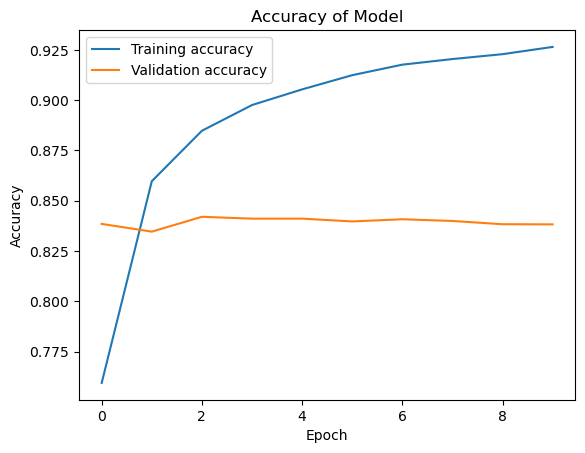

In [61]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title("Accuracy of Model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# plot LOSS

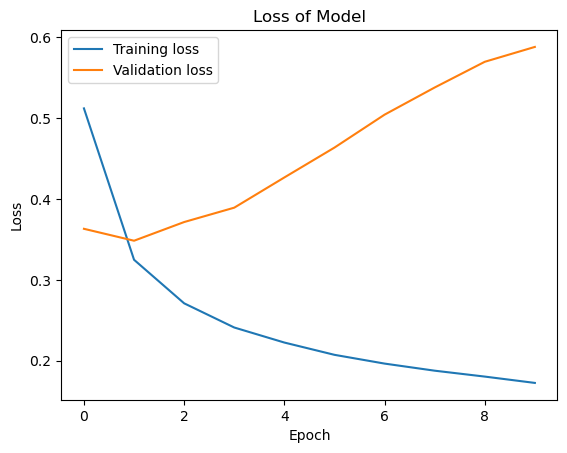

In [62]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [63]:
# Evaluate the model
loss, acc = model.evaluate(test_data, verbose=2)
print("Test Data, accuracy: {:5.2f}%".format(100 * acc))

13/13 - 1s - loss: 0.7826 - accuracy: 0.2606 - 636ms/epoch - 49ms/step
Test Data, accuracy: 26.06%


# LSTM

In [70]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [71]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [72]:
model_LSTM = create_model()

In [73]:
# Evaluate the model
loss, acc = model.evaluate(train_data, verbose=2)
print("Train Data, accuracy: {:5.2f}%".format(100 * acc))

# Evaluate the model
loss, acc = model_LSTM.evaluate(valid_data, verbose=2)
print("Valid Data, accuracy: {:5.2f}%".format(100 * acc))

102/102 - 5s - loss: 0.7444 - accuracy: 0.3120 - 5s/epoch - 45ms/step
Train Data, accuracy: 31.20%
13/13 - -1s - loss: 0.7926 - accuracy: 0.2622 - -993885us/epoch - -76453us/step
Valid Data, accuracy: 26.22%


In [35]:
# history = model.fit(train_data, epochs=5, validation_data=valid_data)

# configure FIT

In [74]:
#checkpoint_path = "wine_0/cp.keras" # If you're saving the whole model, you would use the .keras extension instead
# checkpoint_path = "wine_0/cp-LSTM-{epoch:04d}.keras"
checkpoint_path = "savefiles/cp-LSTM.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
num_epochs=10

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# FIT model

In [75]:

# Train the model with the new callback
history = model_LSTM.fit(
    train_data, 
    epochs=num_epochs, 
    validation_data=valid_data,
    callbacks=[cp_callback],
    verbose=1)


Epoch 1/10
102/102 [==============================] - ETA: 0s - loss: 0.5691 - accuracy: 0.7040
Epoch 1: saving model to savefiles/cp-LSTM.weights.h5
102/102 [==============================] - 64s 616ms/step - loss: 0.5691 - accuracy: 0.7040 - val_loss: 0.3920 - val_accuracy: 0.8370
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8606
Epoch 2: saving model to savefiles/cp-LSTM.weights.h5
102/102 [==============================] - 65s 633ms/step - loss: 0.3583 - accuracy: 0.8606 - val_loss: 0.3542 - val_accuracy: 0.8416
Epoch 3/10
102/102 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8958
Epoch 3: saving model to savefiles/cp-LSTM.weights.h5
102/102 [==============================] - 64s 628ms/step - loss: 0.2736 - accuracy: 0.8958 - val_loss: 0.3759 - val_accuracy: 0.8415
Epoch 4/10
102/102 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9098
Epoch 4: saving model to savefiles/cp-LSTM.weights.h

In [69]:
# Evaluate the model
loss, acc = model_LSTM.evaluate(test_data, verbose=2)
print("Test Data, accuracy: {:5.2f}%".format(100 * acc))

13/13 - 1s - loss: 0.7417 - accuracy: 0.3160 - 644ms/epoch - 50ms/step
Test Data, accuracy: 31.60%


In [38]:
model.save("savefiles/cp-LSTM.keras")

# load Model 1

- ### rebuild model
- ### evaluate

In [172]:
modelLSTM = create_model()

# Evaluate the model
loss, acc = modelLSTM.evaluate(train_data, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

102/102 - 4s - loss: 0.6667 - accuracy: 0.7149 - 4s/epoch - 39ms/step
Untrained model, accuracy: 71.49%


In [173]:
# Loads the weights
# model.load(checkpoint_path)
loaded_model = modelTST.load_weights(checkpoint_path)

# Evaluate the model
loss, acc = modelTST.evaluate(train_data, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

# loaded_model = tf.keras.models.load_model('/home/heidless/projects/heidless-python/dataSci-APPS-2/sandbox/tensorflow-classification/admin/wine_0/cp.keras')

102/102 - 4s - loss: 0.2883 - accuracy: 0.8766 - 4s/epoch - 44ms/step
Untrained model, accuracy: 87.66%
